# Analisis a datos bancarios
Comenzamos con la importacion de las librerias para poder manejar los datos de forma correcta

In [1]:
import pandas as pd
import matplotlib as mpl
import seaborn as sb
import numpy as np

## Obtencion de los datos
Procedemos a obtener los datos en un dataframe para el manejo adecuado de estos. Para su posterior limpieza y modificacion requerida

In [2]:
datos = pd.read_csv('../Datos/bank_customers.csv') # Se reciben los datos en un dataframe desde el archivo

datos.head(5)

,Customer ID,Name,Age,Gender,Address,Email,Phone Number,Account Type,Account Balance,Registration Date
0,24b6ef4a-6310-40de-b589-60d4b75f68e5,Mark Montgomery,47,Female,"52662 Olsen Keys Apt. 350\r\nNew Lauren, KS 90632",sanchezkyle@hotmail.com,190-175-3164x84539,Checking,9391.74,2024-03-19
1,a0ae8e10-73eb-4bfe-8187-5760c4a243e6,Jason King,84,Male,"13849 Romero Stream\r\nJacquelinechester, ND 3...",elewis@hotmail.com,001-985-792-0564,Checking,8395.59,2021-06-19
2,56c99350-9f0f-4cfc-8f8a-379b0c7848df,Steven Whitaker,86,Female,"3801 Brianna Ways\r\nThomasmouth, KY 06857",simmonschristopher@johnston.info,(245)011-5138,Savings,35086.30,2020-06-25
3,31398298-f9c6-40c2-8c56-9a9717c46b65,Terri Lucero,59,Male,026 Norman Villages Suite 475\r\nSouth Christo...,mbeltran@gmail.com,432.911.9239x197,Checking,93745.80,2024-05-17
4,282692f2-6693-4f4d-9beb-50239666f9fc,Jeremy Mason,25,Female,"9115 Lee Route Apt. 784\r\nSanchezmouth, DC 07910",carrie14@gmail.com,001-148-679-2508x961,Checking,3484.77,2021-05-29


# Limpieza y preparacion de los datos
Se preparan los datos cambiando tipos, verificando existencia de nulos y limpiando o modificando datos nulos de existir

In [3]:
datos.isna().sum() # verificacion de existencia de datos nulos

Customer ID          0
Name                 0
Age                  0
Gender               0
Address              0
Email                0
Phone Number         0
Account Type         0
Account Balance      0
Registration Date    0
dtype: int64

Verificamos que datos nulos no existen en los datos entregados, por lo que procedemos a verificar datos duplicados

In [4]:
datos.duplicated().sum() # Verificacion de filas duplicadas

np.int64(0)

Verificamos que no existen filas duplicadas. Por lo que continuamos con la modificacion de los tipos de datos.

In [5]:
datos.dtypes #Mostramos los tipos de datos para cada columna

Customer ID           object
Name                  object
Age                    int64
Gender                object
Address               object
Email                 object
Phone Number          object
Account Type          object
Account Balance      float64
Registration Date     object
dtype: object

Modificaremos los datos de las siguientes columnas:
- Name: object -> string
- Gender: object -> category
- Adress: object -> string
- Email: object -> string
- Phone Number: object -> string
- Account Type: object -> category
- Registration Date: object -> date

In [6]:
datos_modif = datos.copy()
datos_modif = (
    datos_modif.astype({
        'Name': 'string',
        'Gender': 'category',
        'Address': 'string',
        'Email': 'string',
        'Phone Number': 'string',
        'Account Type': 'category'
    })
)

datos_modif["Registration Date"] = pd.to_datetime(datos_modif["Registration Date"])

datos_modif.dtypes

Customer ID                  object
Name                 string[python]
Age                           int64
Gender                     category
Address              string[python]
Email                string[python]
Phone Number         string[python]
Account Type               category
Account Balance             float64
Registration Date    datetime64[ns]
dtype: object

In [7]:
datos_modif.head()

,Customer ID,Name,Age,Gender,Address,Email,Phone Number,Account Type,Account Balance,Registration Date
0,24b6ef4a-6310-40de-b589-60d4b75f68e5,Mark Montgomery,47,Female,"52662 Olsen Keys Apt. 350\r\nNew Lauren, KS 90632",sanchezkyle@hotmail.com,190-175-3164x84539,Checking,9391.74,2024-03-19
1,a0ae8e10-73eb-4bfe-8187-5760c4a243e6,Jason King,84,Male,"13849 Romero Stream\r\nJacquelinechester, ND 3...",elewis@hotmail.com,001-985-792-0564,Checking,8395.59,2021-06-19
2,56c99350-9f0f-4cfc-8f8a-379b0c7848df,Steven Whitaker,86,Female,"3801 Brianna Ways\r\nThomasmouth, KY 06857",simmonschristopher@johnston.info,(245)011-5138,Savings,35086.30,2020-06-25
3,31398298-f9c6-40c2-8c56-9a9717c46b65,Terri Lucero,59,Male,026 Norman Villages Suite 475\r\nSouth Christo...,mbeltran@gmail.com,432.911.9239x197,Checking,93745.80,2024-05-17
4,282692f2-6693-4f4d-9beb-50239666f9fc,Jeremy Mason,25,Female,"9115 Lee Route Apt. 784\r\nSanchezmouth, DC 07910",carrie14@gmail.com,001-148-679-2508x961,Checking,3484.77,2021-05-29


Ya limpios los datos podemos empezar a responder las diferentes preguntas

# ¿Cual es la distribución de Edad y Genero de los Clientes?

In [8]:
#Agrupamos por edad y Genero para contar las cantidades de coincidencias
datos_edad_genero = datos_modif.groupby(['Age', 'Gender']).size().reset_index(name='total')

# Se crean etiquetas para rangos a verificar
valores = ['18 a 19', '20 a 29', '30 a 39', '40 a 49', '50 a 59', '60 a 69', '70 a 79', '80 a 89', '90+']
bins = [18, 20, 30, 40, 50, 60, 70, 80, 90, 100]
datos_edad_genero["edad_bins"] = pd.cut(datos_edad_genero["Age"], bins=bins, labels=valores,
                                                       right=False)


C:\Users\Vicente\AppData\Local\Temp\ipykernel_15000\2656120961.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  datos_edad_genero = datos_modif.groupby(['Age', 'Gender']).size().reset_index(name='total')


[Text(0.5, 0, 'Rangos Edad'),
 Text(0, 0.5, 'Cant. Clientes'),
 Text(0.5, 1.0, 'Distribucion Edad y Genero de Clientes')]

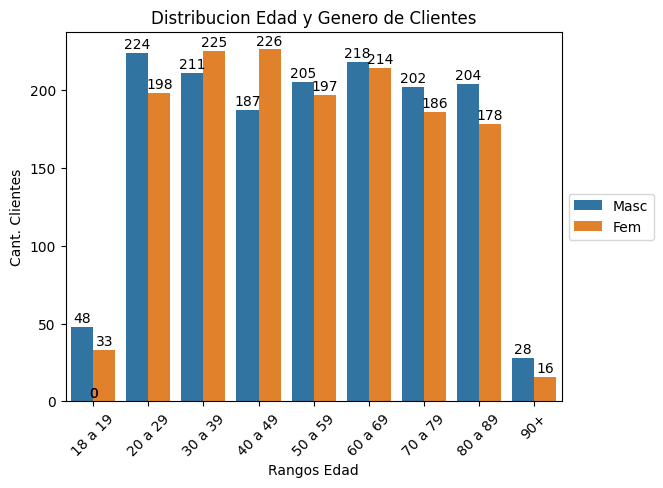

In [9]:
# Creacion del grafico
graf_distrib_edad_genero = sb.barplot(
    data=datos_edad_genero, x='edad_bins', y='total', 
    hue="Gender", hue_order=["Male", "Female"], estimator="sum",errorbar=None
)

#Mostrar los valores de cada barra en el grafico
for p in graf_distrib_edad_genero.patches:
    altura = p.get_height()
    graf_distrib_edad_genero.annotate(
        f'{int(altura)}',
        (p.get_x() + p.get_width() / 2, altura),
        ha='center', va='bottom',
        fontsize=10, color='black', xytext=(0,1),
        textcoords='offset points'
    )

# Modificar nombre de las leyendas
leyendas = graf_distrib_edad_genero.legend(loc='center right', bbox_to_anchor=(1.2, 0.5))
for texto, nombre in zip(leyendas.texts, ["Masc", "Fem"]):
    texto.set_text(nombre)

# modificar valores en el eje x
mpl.pyplot.xticks(rotation=45)
graf_distrib_edad_genero.set(xlabel="Rangos Edad", ylabel="Cant. Clientes", title="Distribucion Edad y Genero de Clientes")

Segun se puede interpretar, la mayoria de los clientes, ya sean hombres o mujeres, se encuentran entre la edades de 20 a 89, los datos minimos estan en los rangos 18 a 19 y 90+ para ambos casos.

Se puede verificar que la cantidad de clientes femeninos va en incremento desde los 18 a los 49, para luego descender un poco de los 49 a los 59, para luego incrementar hasta los 69, para terminar disminuyendo desde los 69 a mas de los 90.

En el caso de los clientes masculinos se ve un incrementeo explosivo entre los 18 a 29, luego disminuye sus de los 39 a 49, para luego incrementar nuevamente de los 49 a los 60 y decrecer de los 69 a mas de los 90.

# ¿Que rangos de edad predominan en para cada tipo de cuenta?

In [10]:
datos_modif["Account Type"].unique().tolist() # Obtenemos los tipos de cuentas en los datos

['Checking', 'Savings']

Con esto sabemos que tipo de cuentas poseemos en el conjunto de datos, para luego poder trabajar los datos de forma correcta.

In [11]:
#Agrupamos por edad y sumamos las cuentas segun los tipos 
datos_tipoCuenta_edad = datos_modif.groupby(['Age'])\
    .agg({
        'Account Type': [
            ('ahorro', lambda x : (x == "Savings").sum()),
            ('cheque', lambda x : (x == "Checking").sum())
        ]
    }).reset_index()

# Se crean etiquetas para rangos a verificar
valores = ['18 a 19', '20 a 29', '30 a 39', '40 a 49', '50 a 59', '60 a 69', '70 a 79', '80 a 89', '90+']
bins = [18, 20, 30, 40, 50, 60, 70, 80, 90, 100]
datos_tipoCuenta_edad["rangos"] = pd.cut(datos_tipoCuenta_edad["Age"], bins=bins, labels=valores,
                                        right=False)

datos_tipoCuenta_edad = datos_tipoCuenta_edad.groupby('rangos')\
    .agg({
        ('Account Type', 'ahorro'): 'sum',
        ('Account Type', 'cheque'): 'sum'
    },
    {'total_cuentas': 'sum'}).reset_index()

datos_tipoCuenta_edad["total_cuentas"] = (datos_tipoCuenta_edad["Account Type"]["ahorro"] 
                                          + datos_tipoCuenta_edad["Account Type"]["cheque"])

datos_tipoCuenta_edad

C:\Users\Vicente\AppData\Local\Temp\ipykernel_15000\3509178001.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  datos_tipoCuenta_edad = datos_tipoCuenta_edad.groupby('rangos')\


rangos Account Type        total_cuentas
                 ahorro cheque              
0  18 a 19           35     46            81
1  20 a 29          218    204           422
2  30 a 39          185    251           436
3  40 a 49          210    203           413
4  50 a 59          188    214           402
5  60 a 69          211    221           432
6  70 a 79          180    208           388
7  80 a 89          194    188           382
8      90+           24     20            44

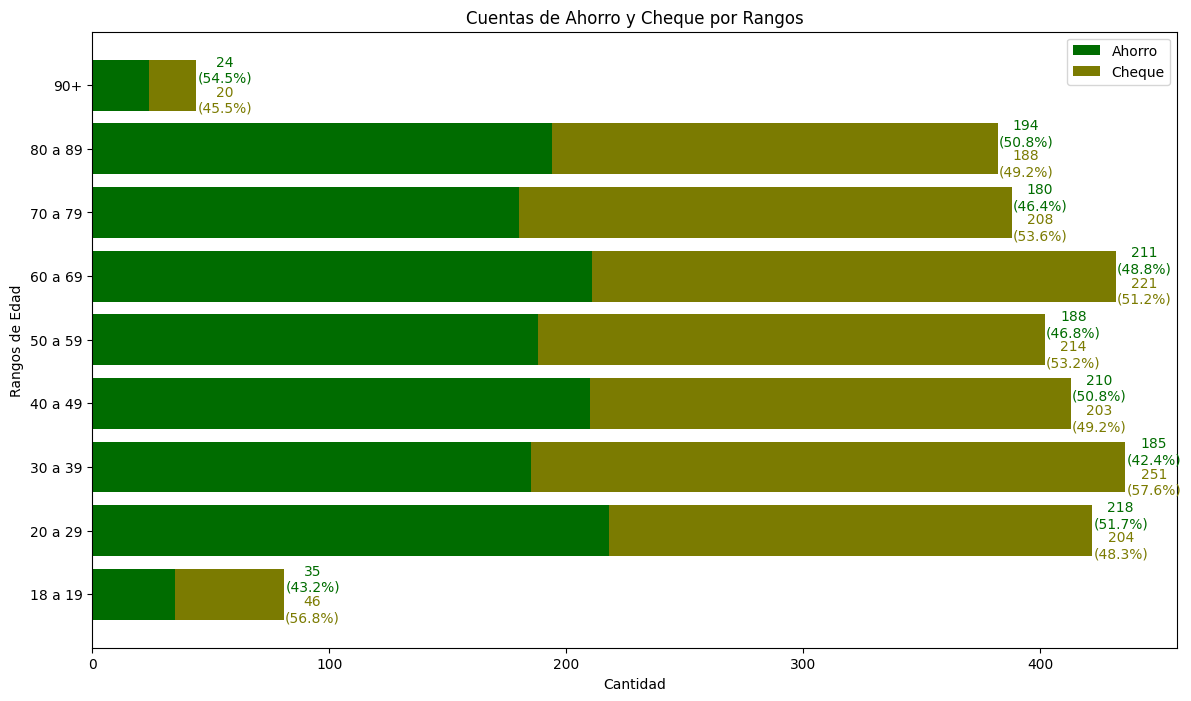

In [12]:
#Creamos el grafico de barras horizontal
# se ingresan los datos
rangos = datos_tipoCuenta_edad['rangos'].astype(str)  # eje y
ahorro = datos_tipoCuenta_edad[('Account Type', 'ahorro')] 
cheque = datos_tipoCuenta_edad[('Account Type', 'cheque')]

#Calculamos el total por rango
total = ahorro + cheque

#Calcular el porcentaje por rango
porc_ahorro = (ahorro / total) * 100
porc_cheque = (cheque / total) * 100

ahorro_vals = ahorro.values
cheque_vals = cheque.values

mpl.pyplot.figure(figsize=(14, 8))

# Posición en eje y
y_pos = np.arange(len(rangos))

# Se agregan las barras
mpl.pyplot.barh(y_pos, ahorro, label='Ahorro', color="#006C00")
mpl.pyplot.barh(y_pos, cheque, left=ahorro, label='Cheque', color="#7B7B01FF")  # se usa left para apilar las barras

mpl.pyplot.yticks(y_pos, rangos)
mpl.pyplot.ylabel('Rangos de Edad')
mpl.pyplot.xlabel('Cantidad')
mpl.pyplot.legend()
mpl.pyplot.title('Cuentas de Ahorro y Cheque por Rangos')

#Se agregan etiquetas de cantidad y porcentaje para ahorro
for i in range(len(rangos)):
    mpl.pyplot.text( ahorro[i]+cheque[i]+12, y_pos[i], f"{ahorro_vals[i]}\n({porc_ahorro.iloc[i]:.1f}%)", va='bottom', ha='center', 
                    color='#006C00')

#Etiquetas de barras cheque
for i in range(len(rangos)):
    mpl.pyplot.text(ahorro[i]+cheque[i]+12, y_pos[i], f"{cheque_vals[i]}\n({porc_cheque.iloc[i]:.1f}%)",va='top', ha='center', 
                    color="#7B7B01FF" )


mpl.pyplot.show()


In [13]:
# cant_tipoCuenta_total_porcent = datos_modif.groupby(['Account Type']).sum()
cant_porcent_datos_tipoCuenta = datos_modif.groupby("Account Type").size().reset_index(name='total')

cant_porcent_datos_tipoCuenta["porc_total"] = (cant_porcent_datos_tipoCuenta["total"]/cant_porcent_datos_tipoCuenta["total"].sum())*100

cant_porcent_datos_tipoCuenta


C:\Users\Vicente\AppData\Local\Temp\ipykernel_15000\500369001.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cant_porcent_datos_tipoCuenta = datos_modif.groupby("Account Type").size().reset_index(name='total')


,Account Type,total,porc_total
0,Checking,1555,51.833333
1,Savings,1445,48.166667


Como se puede ver en el grafico, las predominancias segun rango etario serian las siguientes:
- 90+: Cuenta tipo Cheque con 54.5%
- 80 a 89: Cuenta tipo Ahorro con 50.8%
- 70 a 79: Cuenta tipo Cheque con 53.6%
- 60 a 69: Cuenta tipo Cheque con 51.2%
- 50 a 59: Cuenta tipo Cheque con 53.2%
- 40 a 49: Cuenta tipo Ahorro con 50.8%
- 30 a 39: Cuenta tipo Cheque con 57.6%
- 20 a 29: Cuenta tipo Ahorro con 51.7%
- 18 a 19: Cuenta tipo Cheque con 56.8%

Por lo que se puede ver que en el universo de datos analizados predomina el tipo de cuenta "Cheque"(Chekings) con 1555 cuentas lo que equvale al 54.8% contra las cuenta de ahorro(Savings) con 1445 lo que equivale al 48.2% del total

# ¿Cuál es la distribución geográfica (basada en dirección) de los clientes?
Para poder verificar esto, obtendremos la informacion y los limpiaremos el dato de dirección que poseen los datos

In [14]:
datos_modif.columns

Index(['Customer ID', 'Name', 'Age', 'Gender', 'Address', 'Email',
       'Phone Number', 'Account Type', 'Account Balance', 'Registration Date'],
      dtype='object')

In [15]:
# Obtener datos a manejar
distrib_geograf = datos_modif[["Customer ID", "Address"]].copy()
distrib_geograf_noModif = datos_modif[["Customer ID", "Address"]].copy()

# Separaremos la dirección de su estado
distrib_geograf["State"] = distrib_geograf["Address"].str.split(',').str[1].str.split(' ').str[1]
distrib_geograf_noModif["State"] = distrib_geograf_noModif["Address"].str.split(',').str[1].str.split(' ').str[1]

# # Convertir State a string
distrib_geograf = distrib_geograf.astype({'State': 'string'})

#Condiciones de modificacion de estados militares
condicionAA = distrib_geograf["Address"].str.contains(' AA ')
condicionAP = distrib_geograf["Address"].str.contains(' AP ')
condicionAE = distrib_geograf["Address"].str.contains(' AE ')

# modificaciones a estados militares
distrib_geograf.loc[condicionAA, 'State'] = 'AA'
distrib_geograf.loc[condicionAP, 'State'] = 'AP'
distrib_geograf.loc[condicionAE, 'State'] = 'AE'

# Creacion de la tabla para el grafico de distribucion geografica
distrib_geograf = distrib_geograf.groupby('State').agg(clientes=('Customer ID', 'count'))
distrib_geograf.head()

,clientes
State,
AA,92
AE,93
AK,50
AL,54
AP,103


Ya obtenida la tabla para la distribucion geografica, procedemos a crear el grafico

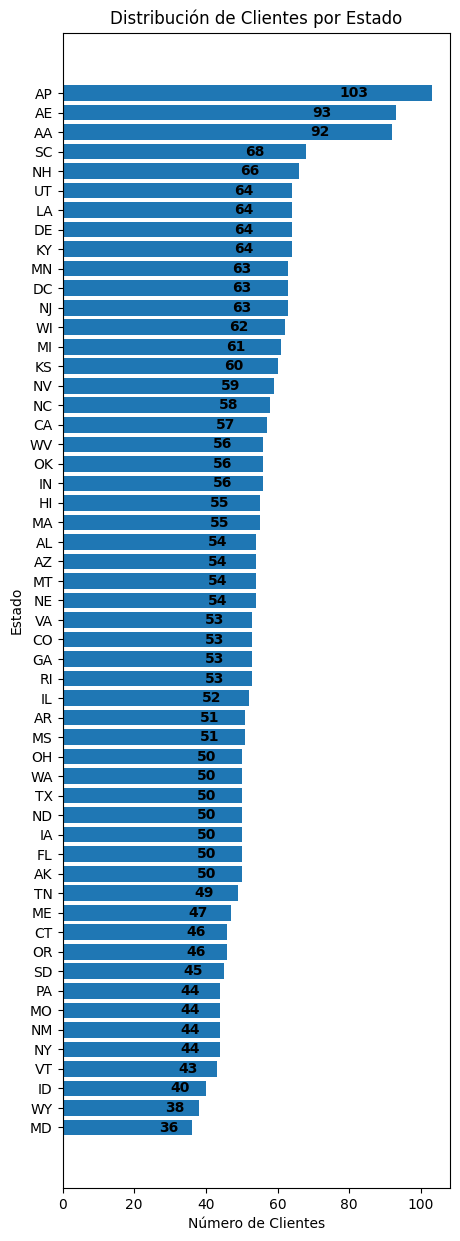

In [16]:
# Se ordena de mayor a menor la tabla
distrib_geograf = distrib_geograf.sort_values("clientes",ascending=True)


mpl.pyplot.figure(figsize=(5, 15))  # Tamaño ajustable
grafico_dist_geograf = mpl.pyplot.barh(distrib_geograf.index, distrib_geograf['clientes'])
mpl.pyplot.xlabel('Número de Clientes')
mpl.pyplot.ylabel('Estado')
mpl.pyplot.title('Distribución de Clientes por Estado')

# Se muestra la etiqueta de graficos
for i, barra in enumerate(grafico_dist_geograf):
    ancho = barra.get_width() # Se obtiene el ancho de las barras
    mpl.pyplot.text( ancho*0.75, barra.get_y() + barra.get_height()/2, # posicion ligeramente a la derecha
                    f'{int(ancho)}', # Valor entero de la etiqueta
                    ha='left',  va='center', fontsize=10, fontweight='bold') # Alienacion y estilo

mpl.pyplot.show()  # Muestra el gráfico

**Para informacion del usuario, se encontraron 3 estados que no coincidian a estados presentes en Estados Unidos( AP, AE, AA), estos corresponden a direcciones militares para correo postal en el extranjero.**

Tomando lo dicho en la parte superior y mirando el grafico los datos terminan de la siguiente manera:

- El top 5 de estados con mayor cantidad de clientes tomando en cuenta las postales militares son:
    - AP (Armed Forces Pacific) con 103 clientes
    - AE (Armed Forces Europe, Middle East, Africa, and Canada) con 96 clientes
    - AA (Armed Forces Americas) con 95 clientes
    - SC (Carolina del Sur) con 68 clientes
    - NH (Nuevo Hampshire) con 66 Clientes

- En caso de no tomarlos en cuenta el top 5 serian:
    - SC (Carolina del Sur) con 68 clientes
    - NH (Nuevo Hampshire) con 66 Clientes
    - UT (Utah) con 64 clientes
    - LA (Luisiana) con 64 clientes
    - DE (Delawere) con 64 clientes

- Como se puede apreciar en el grafico, los estados con menos clientes son MD, WY, ID, VT

Estos datos nos dan a entender la disposicion geografica de los clientes, destacando con grandes cantidades los estados de direcciones militares frente a los estados civiles.


# ¿Cuál es el rango y promedio del saldo de cuenta por tipo de cuenta?

Se procede a obtener los datos necesarios para el analisis de esta pregunta.

In [39]:
# Obtenemos la copia para atacar esta pregunta
rangoPromSaldo_tipoCuenta = datos_modif.copy().groupby("Account Type",observed=False)\
        .agg(
            saldo_min = ("Account Balance", "min"),
            saldo_max = ("Account Balance", "max"),
            saldo_prom = ("Account Balance", "mean")
        ).reset_index()

rangoPromSaldo_tipoCuenta

,Account Type,saldo_min,saldo_max,saldo_prom
0,Checking,225.96,99973.61,51192.643563
1,Savings,100.77,99965.69,50377.879945


Obtenidos los datos pasamos a usarlos para el grafico

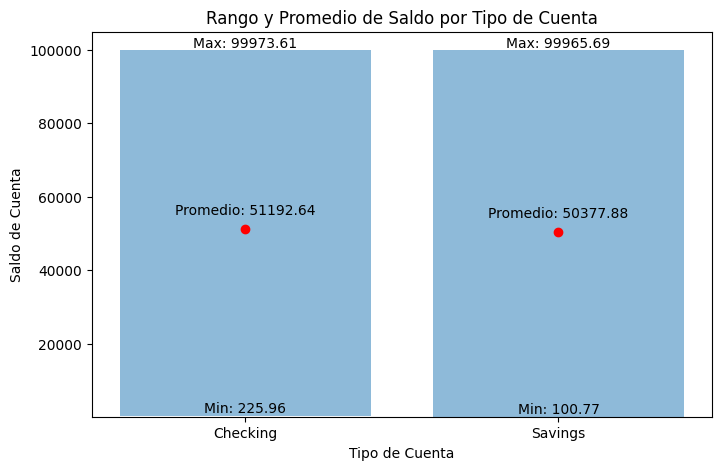

In [18]:
# Obtenemos el rango que poseen los datos
x = np.arange(len(rangoPromSaldo_tipoCuenta))

fig, ax = mpl.pyplot.subplots(figsize=(8,5)) # Posiciones en el eje x

# barras para el rango min a max 
barras = ax.bar(x, rangoPromSaldo_tipoCuenta["saldo_max"] - rangoPromSaldo_tipoCuenta["saldo_min"], 
                bottom=rangoPromSaldo_tipoCuenta["saldo_min"], alpha=0.5 )

# Agregamos puntos para el promedio 
ax.scatter(x, rangoPromSaldo_tipoCuenta["saldo_prom"], color='red', label='Promedio', zorder=5)

# Etiquetas y leyendas
ax.set_xticks(x) # Cantidad de barras
ax.set_xticklabels(rangoPromSaldo_tipoCuenta["Account Type"]) # Agregar etiqueta de tipo de cuenta
# Etiquetas Grafico
ax.set_ylabel('Saldo de Cuenta')
ax.set_xlabel('Tipo de Cuenta')
ax.set_title('Rango y Promedio de Saldo por Tipo de Cuenta')

# Agregar etiquetas para min, max y promedio por barra
for i in x:
    ax.text(i, rangoPromSaldo_tipoCuenta["saldo_min"][i]+4000, 
        f'Min: {rangoPromSaldo_tipoCuenta['saldo_min'][i]:.2f}', ha='center', va='top', fontsize=10)
    ax.text(i, rangoPromSaldo_tipoCuenta["saldo_max"][i], 
        f'Max: {rangoPromSaldo_tipoCuenta['saldo_max'][i]:.2f}', ha='center', va='bottom', fontsize=10)
    ax.text(i, rangoPromSaldo_tipoCuenta["saldo_prom"][i]+5000,
        f'Promedio: {rangoPromSaldo_tipoCuenta["saldo_prom"][i]:.2f}', ha='center', va='center', fontsize=10 )



Como se puede visualizar en el grafico, vemos que el promedio es muy cercano entre los tipos de cuentas en los datos.

| Tipo de Cuenta | Promedio (Saldo) |
|----------------|------------------|
| **Checking**  | 5,119.64        | 
| **Savings**   | 5,037.88        |

Lo que nos dice que existe un equilibrio en el uso de los tipos de cuentas.

En temas de rangos, tenemos los siguientes datos.

| Tipo de Cuenta | Mínimo (Saldo) | Máximo (Saldo) |
|----------------|----------------|-------------------|
| **Checking**  | 225.96        | 99,973.61      |
| **Savings**   | 100.77        | 99,965.69     | 

Lo que nos dice que, el promedio de cada tipo de cuenta es muy similar, por lo que podemos decir que los tipos de cuentas pueden ser igual de volatiles entre ellas, ademas al ser los datos altos muy similares, nos dice tambien que existen clientes de alto valor en ambos categorias. Destacando que la diferencias del minimo entre las cuentas es bastante significativa (100.77 para Savings y 225.96 para Cheking).

# ¿Existe alguna relación entre edad, tipo de cuenta y saldo promedio?
Procederemos a verificar si existe una relacion entre edad y saldo promedio por tipo de cuenta.

In [38]:
# Obtenemos una copia para trabajar los datos
datos_dispersion = datos_modif.copy()

# Obtenemos el promedio de saldo por edad
promedioSaldo_edad = datos_dispersion.groupby(["Age", "Account Type"],observed=False).agg(
    promedio_saldo = ("Account Balance", "mean")
).reset_index()

# Ponemos como maximo 2 decimales a los promedios
promedioSaldo_edad["promedio_saldo"] = promedioSaldo_edad["promedio_saldo"].round(2)

correlacion = promedioSaldo_edad[["Age", "promedio_saldo"]].corr(method="pearson")

correlacion

,Age,promedio_saldo
Age,1.00000,-0.08349
promedio_saldo,-0.08349,1.00000


Al  hacer un analisis basico de correlacion entre la edad y el promedio de saldo, nos arroja que esta es ligeramente debil. Lo que significa que el saldo promedio debe disminuir segun la edad avanza pero de forma muy leve.

d:\Proyectos de Analisis de datos\analisisDatos_clientesBancarios\Analisis\analisis_bancario\Lib\site-packages\seaborn\regression.py:598: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


<Figure size 1200x500 with 0 Axes>

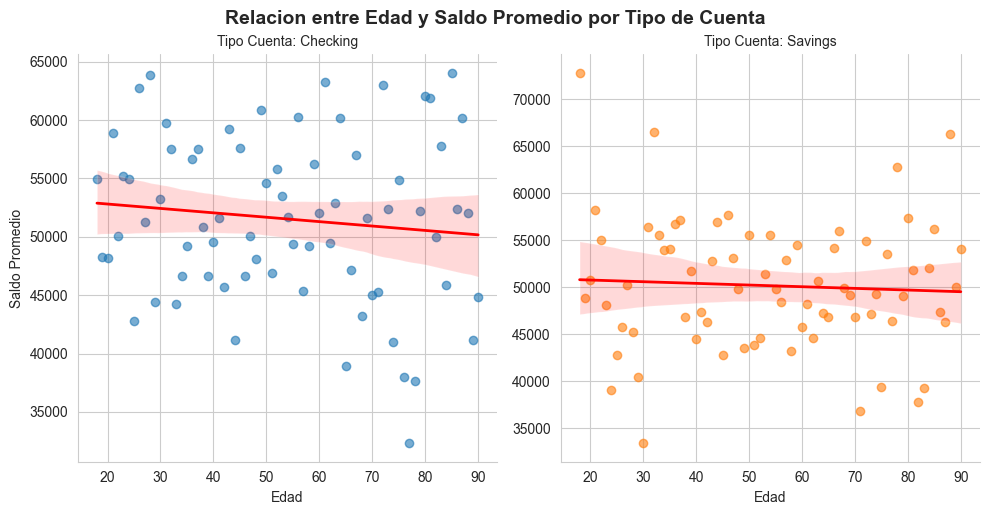

In [20]:
# Creamos el grafico de dispersion.
# Configuracion para mejor legibilidad
sb.set_style("whitegrid")
mpl.pyplot.figure( figsize=(12,5) ) # Tamaño de de espacios

#Graficos
grafs = sb.lmplot(
    data=promedioSaldo_edad, x="Age", y="promedio_saldo", hue="Account Type",
    col="Account Type", ci=95, # Separacion por tipo cuenta,  intervalo de confianza
    scatter_kws={'alpha':0.6}, # transparencia para siperposiciones
    line_kws={'color': 'red', 'lw': 2}, # Grosor de linea 
    sharey=False
)

# Etiquetas
grafs.set_axis_labels("Edad", "Saldo Promedio")
grafs.set_titles("Tipo Cuenta: {col_name}") # formato titulos graficos
grafs.fig.suptitle("Relacion entre Edad y Saldo Promedio por Tipo de Cuenta", y=1.02, fontsize=14, 
                   fontweight='bold')



mpl.pyplot.show()

Al analizar los graficos separados por tipo de cuenta podemos ver lo siguiente:

Existe una relacion negativa para ambos tipos de cuentas, pero lo que cambia entre estas es la reduccion de los saldos. En las cuentas de tipo Checking hay una relacion negativa moderada lo que quieres decir que la perdida de saldo en estas cuentas es considerable. En cambio las cuentas de tipo Savings posee una relacion nula/debil, es decir, estas si bien pierden mediante la edad de los clientes, no es significativo, por lo que mantiene el valor de los ingresos de los clientes.

Por lo que el tipo de cuenta si afecta a los clientes de forma moderada. La edad en cambio afecta de forma diferencial entre tipos de cuenta, pero si hablamos en forma global, se puede ver una ligera disminucion de saldos con la edad (Como lo demuestra la correlacion hecha unos cuadros mas arriba).


# ¿Cómo varía el saldo promedio según el género?

In [23]:
datos_modif.columns

Index(['Customer ID', 'Name', 'Age', 'Gender', 'Address', 'Email',
       'Phone Number', 'Account Type', 'Account Balance', 'Registration Date'],
      dtype='object')

In [37]:
# Obtenemos los datos
sueldoProm_genero = datos_modif.copy().groupby("Gender",observed=False)\
    .agg(saldo_promedio = ("Account Balance","mean"))

sueldoProm_genero["saldo_promedio"] = sueldoProm_genero["saldo_promedio"].round(2)

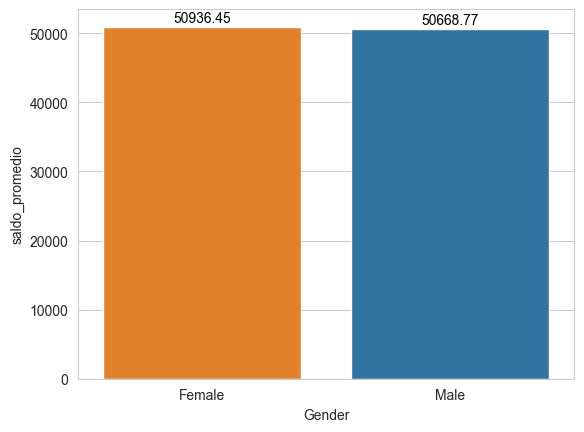

In [44]:
# Creacion del grafico
grafbar_saldoProm_genero = sb.barplot(
    data=sueldoProm_genero, x='Gender', y='saldo_promedio', 
    hue="Gender", hue_order=["Male", "Female"],errorbar=None
)

#Mostrar los valores de cada barra en el grafico
for p in grafbar_saldoProm_genero.patches:
    altura = p.get_height()
    grafbar_saldoProm_genero.annotate(
        f'{float(altura)}',
        (p.get_x() + p.get_width() / 2, altura),
        ha='center', va='bottom',
        fontsize=10, color='black', xytext=(0,1),
        textcoords='offset points'
    )

# ¿Cuándo se registran más clientes, en qué fechas o meses?
Procederemos a verificar en que momento se registran mas clientes

In [ ]:
registros_mes = datos_modif.copy()

In [ ]:
# Agrupar los datos por años_meses
registros_mes["year_month"] = registros_mes["Registration Date"].dt.to_period('M')
registros_meses_años = registros_mes.groupby("year_month").agg(total=("Customer ID", "count")).reset_index()

# obtener lista de años
años = registros_mes["Registration Date"].dt.year.unique()

# Se ordenan los años
años = sorted(años)

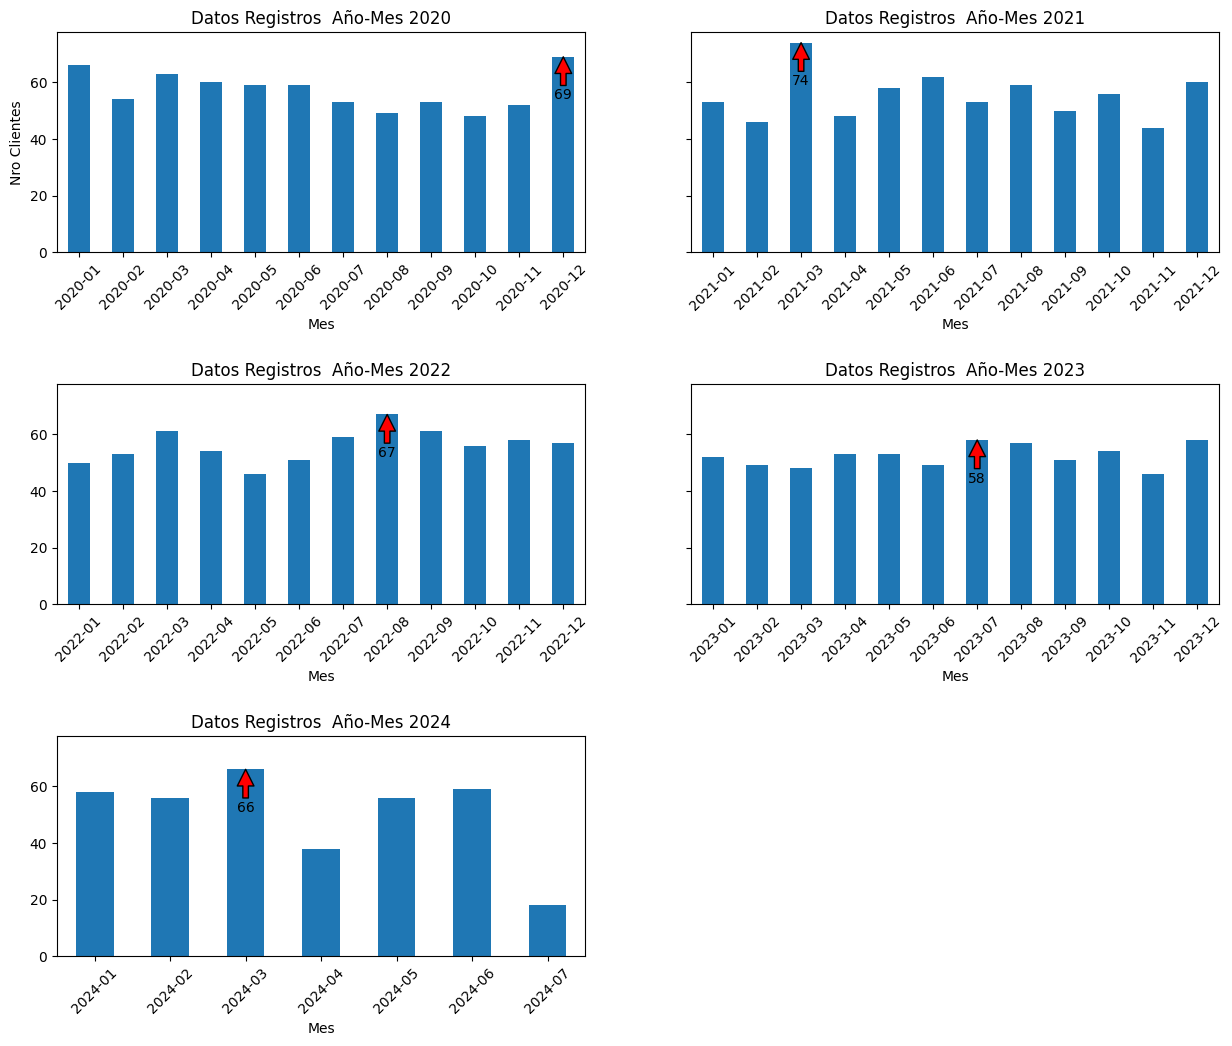

In [ ]:
# Confeccion de graficos multiples
fig, axes = mpl.pyplot.subplots( 3, 2, figsize=(15,12), sharey=True)

# Se agrega espacio entre filas de graficos para mejor lectura
fig.subplots_adjust(hspace=0.6)

axes = axes.flatten() # Se aplana la figura del grafico

# Se recorren los años
for i, año in enumerate(años):
    # Se filtran por año y se agrupa por el mes
    datos_años = registros_mes[ registros_mes['Registration Date'].dt.year == año ].groupby("year_month")\
        .agg(total=("Customer ID", "count")).reset_index()
    
    max_año = datos_años["total"].max()
    
    # Se crean los graficos a mostrar
    datos_años.plot(kind="bar", ax=axes[i], legend=False)
    axes[i].set_title(f'Datos Registros  Año-Mes {año}')
    axes[i].set_xlabel(f'Mes')

    if i == 0:
        axes[i].set_ylabel('Nro Clientes')
    
    # Poner los valores de year_month en el eje x
    axes[i].set_xticks(range(len(datos_años)))
    axes[i].set_xticklabels(datos_años['year_month'], rotation=45)

    # Obtener índice del máximo para saber dónde poner anotación
    idx_max = datos_años['total'].idxmax()
    # Anotar el máximo en el gráfico
    axes[i].annotate(f'{max_año}', xy=(idx_max, max_año), xytext=(idx_max, max_año - 15),
        arrowprops=dict(facecolor='red', shrink=1), ha='center')

# Se elimina el ultimo grafico, que esta sin datos 
if len(años) < len(axes):
    for j in range(len(años), len(axes)):
        fig.delaxes(axes[j])

# Se muestra la informacion
mpl.pyplot.show()

Segun se puede verificar en el grafico, los meses de maximos registros son los siguientes:

| Año   | Mes pico          | Número de clientes |
|-------|-------------------|--------------------|
| 2020  | Octubre (10/2020) | 69                 |
| 2021  | Enero (01/2021)   | 74                 |
| 2022  | Julio (07/2022)   | 67                 |
| 2023  | Agosto (08/2023)  | 58                 |
| 2024* | Febrero (02/2024) | 66                 |

*Nota: Los datos de 2024 solo cubren hasta julio.

La Cantidad maxima en la totalidad de los años fue de 74 clientes para el mes de Enero de 2021, el minimo de los maximos fue para el año 2023 en el mes de Agosto con una cantidad de 58 clientes.

Se puede ver que calculando, el promedio de los maximos es de 66.8 clientes por año, por lo que los años que se destacan cumpliendo el promedio de registros de clientes es son 2020, 2021 y 2022. Mietras que los años que no lograron el promedio calculado por años fueron el 2023 y 2024 (Destacando que este no esta completo en los datos analizados).

Por lo que la tendencia general esta en los meses de invierno( Para USA, Enero - Febrero ) o mitad de año (Julio - Agosto - Octubre) con un promedio de maximos anuales de 66.8 registro de clientes.